In [21]:
#! pip install ultralytics 
#! pip install psycopg2
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import psycopg2
#import im_utils
import db_ops
import pandas as pd
import im_utils

import cv2

import tensorflow as tf
print(tf.__version__)

from keras.models import Model
from keras.saving import load_model

from ultralytics import YOLO

2.16.2


In [22]:
test_lbls = ['5-hour energy', '99', 'AW', 'Acadia', 'Arizona', 'Bang', 'Big Gulp', 'Bill Miller', 'Boulevard Brewing', 'Brisk', 'bud_light', 'Budweiser', 'Burger King', 'busch_light', 'Camel', 'Cheetos', 'Coca Cola', 'Coors', 'Corona', 'Dasani', 'Dasy', 'David', 'Deer Park', 'Doritos', 'Dunkin Donuts', 'Evan Williams', 'Fanta', 'Fireball', 'Flow', 'Fruit Punch', 'Gatorade', 'GoGo', 'Google', 'Goya', 'Grace', 'Green Mountain', 'Heineken', 'Hersheys', 'Hill Country Fair', 'Icehouse Edge', 'Jarritos', 'Jim Beam', 'Kirkland', 'Kit Kat', 'Kool-Aid', 'La Yogurt', 'LaCroix', 'Lays', 'Lybbis', 'Marlboro', 'McDonalds', 'Mentos', 'Michelob', 'Miller', 'Milwakee Best Ice', 'MnM', 'Modelo', 'Monster', 'Mountain Dew', 'Natural Ice', 'New Amsterdam', 'Niagara', 'Oreo', 'pbr', 'Pacifico', 'Pampers', 'Parliament', 'Peaceful Fruits', 'Perrier', 'Poland Spring', 'Popeyes', 'PurAqua', 'Redbull', 'Ross Ouzo', 'Sams Club', 'Samuel Adams', 'Sangria Senorial', 'Sanpple', 'Seven eleven', 'Shasta', 'Silver Falls', 'Slurpee', 'Smirnoff', 'Snickers', 'Sprite', 'Stella', 'Turkey Hill', 'Twix', 'Two Ball', 'Vitamin', 'Welchs', 'Yoohoo']
test_lbls = [x.lower().replace(' ', '_') for x in test_lbls]

In [23]:
label_path = '../random_test_dataset/train/labels'
lbl_files = os.listdir(label_path)
file_names = []
labels = []
lst_cent_x = []
lst_cent_y = []
lst_box_w = []
lst_box_h = []

for file in lbl_files:
    file_name = file.split('_jpg')[0]
    with open(label_path + '/'+file, 'r') as label_file:
        for line in label_file:
            idx, cent_x, cent_y, box_w, box_h = line.split(' ')
            lst_cent_x.append(float(cent_x))
            lst_cent_y.append(float(cent_y))
            lst_box_w.append(float(box_w))
            lst_box_h.append(float(box_h))
            labels.append(test_lbls[int(idx)].lower())
            file_names.append(file_name)
        
test_labels_df = pd.DataFrame({'im_name':file_names,
                               'true': labels,
                                'cent_x': lst_cent_x,
                                'cent_y': lst_cent_y,
                                'box_w': lst_box_w,
                                'box_h': lst_box_h}, index = range(len(file_names)))
test_labels_df['box_id'] = range(len(test_labels_df))

In [24]:
image_path = '../random_test_dataset/train/images'
files = os.listdir(image_path)
image_names = [file.split('_jpg')[0] for file in files]

In [25]:
'''
# load image classification model
classifier = load_model("./models/B0_EffNet_classifier.keras")

# load dataframe that correlated model index and database ID
id_idx_df = pd.read_csv('brand_ids_idx.csv', sep = '\t')

# load logo detection model
detector = YOLO('./models/logo_detector.pt')
'''

'\n# load image classification model\nclassifier = load_model("./models/B0_EffNet_classifier.keras")\n\n# load dataframe that correlated model index and database ID\nid_idx_df = pd.read_csv(\'brand_ids_idx.csv\', sep = \'\t\')\n\n# load logo detection model\ndetector = YOLO(\'./models/logo_detector.pt\')\n'

In [26]:
'''
# Detection stage
boxes_df = pd.DataFrame(columns = ['im_name', 'xmin_coord', 'ymin_coord', 'xmax_coord', 'ymax_coord', 'box_conf', 'brand', 'predicted'])

for file in files:
    print('-'*30)
    try:
        # Scale the image and write to the local folder  
        image_original = cv2.imread(os.path.join(image_path, file))
        image_scaled = im_utils.ScaleImage(image_original, width = 640)
        
        # Run logo detector
        results = detector(image_scaled, conf = 0.25)
        
        # Find the saceling factor
        w_ratio = image_original.shape[1]/image_scaled.shape[1]
        h_ratio = image_original.shape[0]/image_scaled.shape[0]
        for i in range(len(results[0].boxes.xyxy)):   # Iterate over each box
            # Get the coordinates of the box on the original image
            xmin, ymin, xmax, ymax = map(int, results[0].boxes.xyxy[i]) 
            xmin = int(xmin * w_ratio)
            xmax = int(xmax * w_ratio)
            ymin = int(ymin * h_ratio)
            ymax = int(ymax * h_ratio)

            # Get the section of the original image that is in the box
            box_im = image_original[ymin:ymax, xmin:xmax,:]

            # Run the logo classifier on this box
            box_im = cv2.resize(box_im, (254,254))
            y_pred = classifier.predict(box_im.reshape(1,254,254,3))
            y_pred_dense = np.argmax(y_pred, axis=1)
            brand_name_df = id_idx_df[id_idx_df['idx'] == y_pred_dense[0]]
            
            # Save the box locally as an individual file
            idx = len(boxes_df)
            boxes_df.loc[idx, 'im_name'] = file.split('_jpg')[0]
            boxes_df.loc[idx, 'xmin_coord'] = xmin
            boxes_df.loc[idx, 'ymin_coord'] = ymin
            boxes_df.loc[idx, 'xmax_coord'] = xmax
            boxes_df.loc[idx, 'ymax_coord'] = ymax
            boxes_df.loc[idx, 'box_conf'] = float(results[0].boxes.conf[i])
            boxes_df.loc[idx, 'brand_conf'] = max(y_pred[0])
            boxes_df.loc[idx, 'predicted'] = brand_name_df['brand_name'].iloc[0]
    except Exception as e:
        print(e)

# Save predictions 
boxes_df.to_csv('EffNet_boxes.csv', sep='\t', index=False)
'''

"\n# Detection stage\nboxes_df = pd.DataFrame(columns = ['im_name', 'xmin_coord', 'ymin_coord', 'xmax_coord', 'ymax_coord', 'box_conf', 'brand', 'predicted'])\n\nfor file in files:\n    print('-'*30)\n    try:\n        # Scale the image and write to the local folder  \n        image_original = cv2.imread(os.path.join(image_path, file))\n        image_scaled = im_utils.ScaleImage(image_original, width = 640)\n        \n        # Run logo detector\n        results = detector(image_scaled, conf = 0.25)\n        \n        # Find the saceling factor\n        w_ratio = image_original.shape[1]/image_scaled.shape[1]\n        h_ratio = image_original.shape[0]/image_scaled.shape[0]\n        for i in range(len(results[0].boxes.xyxy)):   # Iterate over each box\n            # Get the coordinates of the box on the original image\n            xmin, ymin, xmax, ymax = map(int, results[0].boxes.xyxy[i]) \n            xmin = int(xmin * w_ratio)\n            xmax = int(xmax * w_ratio)\n            ymin 

In [27]:
# Read saved predictions to not re-run the prediction job
boxes_df_read = pd.read_csv('EffNet_boxes.csv', sep='\t')
boxes_df_read['box_id'] = range(len(test_labels_df), len(test_labels_df) + len(boxes_df_read))
boxes_df_read.rename(columns={'brand_predicted':'predicted'}, inplace=True)

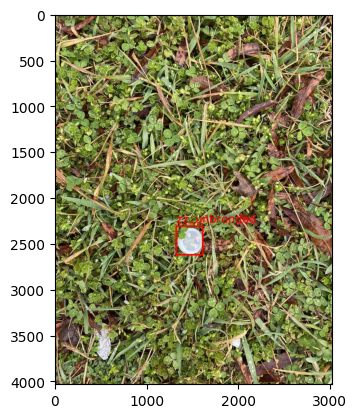

In [28]:
thr = 0.15
#im_file = 'IMG_6420_jpg.rf.7d5c73f52763c52e8df0e3cdb7acb41e.jpg'
#im_name  = im_file.split('_jpg')[0]

im_name = 'IMG_6727'
im_file = [file for file in os.listdir(image_path) if im_name in file][0]

# Get the data slices for this image
true_labels_df = test_labels_df[test_labels_df['im_name'] == im_name].copy()
pred_labels_df = boxes_df_read[boxes_df_read['im_name']==im_name].copy()

# Convert the YOLO notation to coordinates
# Get the dimentions of the original image
file_path = os.path.join(image_path, im_file)
im_orig = cv2.imread(file_path)
im_h, im_w = im_orig.shape[:2]
# Recalculate coordinates
true_labels_df['xmin_coord'] = (im_w * true_labels_df['cent_x'] - 0.5*im_w*true_labels_df['box_w']).astype(int)
true_labels_df['xmax_coord'] = (im_w * true_labels_df['cent_x'] + 0.5*im_w*true_labels_df['box_w']).astype(int)
true_labels_df['ymin_coord'] = (im_h * true_labels_df['cent_y'] - 0.5*im_h*true_labels_df['box_h']).astype(int)
true_labels_df['ymax_coord'] = (im_h * true_labels_df['cent_y'] + 0.5*im_h*true_labels_df['box_h']).astype(int)

# Go over each true lable in this image
for i in range(len(true_labels_df)): 
	dict_IoU = {-1:-1} # make a dict of pred_box_id:IoU pairs for this true box
	# Construct a box for the true box
	boxA = true_labels_df['xmin_coord'].iloc[i], true_labels_df['ymin_coord'].iloc[i], \
		true_labels_df['xmax_coord'].iloc[i], true_labels_df['ymax_coord'].iloc[i] 

	# Go over every predicted box
	for j in range(len(pred_labels_df)): # calculate IoU between true and predicted box
		boxB = pred_labels_df['xmin_coord'].iloc[j], pred_labels_df['ymin_coord'].iloc[j],\
			pred_labels_df['xmax_coord'].iloc[j], pred_labels_df['ymax_coord'].iloc[j] 
		dict_IoU[pred_labels_df['box_id'].iloc[j]] = bb_iou(boxA, boxB)

	# Find the ID of the box that overlaps the most
	max_box_id = max(dict_IoU, key=dict_IoU.get)
	# If its IoU is above threshold
	# update the box ID of predicted box to match ID of the true box
	if dict_IoU[max_box_id] > thr:
		idx = pred_labels_df[pred_labels_df['box_id'] == max_box_id].index
		pred_labels_df.at[idx[0], 'box_id'] =  true_labels_df['box_id'].iloc[i]

# Collect both true and predicted boxes in the image
image_boxes_df = pd.merge(true_labels_df, pred_labels_df, on='box_id', how='outer')

# Make a column with image name, given that pred or true can be empty
image_boxes_df['im_name'] = image_boxes_df['im_name_x'].fillna(image_boxes_df['im_name_y'])

# Calcualte total confidence for the predictions
# No precitions is the same as predicting background, 
# mAP does not include it background, so put 1, whatever
image_boxes_df['conf'] = image_boxes_df['box_conf'] * image_boxes_df['brand_conf']
image_boxes_df['conf'] = image_boxes_df['conf'].fillna(1)

# No label means background
image_boxes_df[['predicted', 'true']] = image_boxes_df[['predicted', 'true']].fillna('background')

# Get only the columns we need
image_boxes_df = image_boxes_df[['im_name', 'conf', 'predicted', 'true', 'box_id']]

# Draw ground truth boxes:
# for each box, draw the box and label
for box_params in true_labels_df[['true', 'xmin_coord', 'ymin_coord', 'xmax_coord', 'ymax_coord']].values:
	lbl, x1, y1, x2, y2 = box_params
	color = (0,255,0)
	cv2.rectangle(im_orig, (x1,y1), (x2,y2), color, 15)
	cv2.putText(im_orig, lbl, (x1,y1-40), cv2.FONT_HERSHEY_SIMPLEX, 4, color, 10, cv2.LINE_AA)

# Draw predicted boxes 
for box_params in pred_labels_df[['predicted', 'xmin_coord', 'ymin_coord', 'xmax_coord', 'ymax_coord']].values:
	lbl, x1, y1, x2, y2 = box_params
	color = (0,0,255)
	cv2.rectangle(im_orig, (x1,y1), (x2,y2), color, 15)
	cv2.putText(im_orig, lbl, (x1,y1-40), cv2.FONT_HERSHEY_SIMPLEX, 4, color, 10, cv2.LINE_AA)

#Show the picture
plt.imshow(cv2.cvtColor(im_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [29]:
image_boxes_df

,im_name,conf,predicted,true,box_id
0,IMG_6727,0.704845,zz_unbranded,background,328


In [30]:
def bb_iou(boxA, boxB):
	# Make the field that covers both boxes
	y_max = max(boxA[3], boxB[3])
	x_max = max(boxA[2], boxB[2])
	field = np.zeros((y_max, x_max))

	#Make masks for the boxes
	maskA = field.copy()
	maskA[boxA[1]:boxA[3], boxA[0]:boxA[2]] = 1

	maskB = field.copy()
	maskB[boxB[1]:boxB[3], boxB[0]:boxB[2]] = 1

	#Use np logical functions to find IoU
	intersection = (np.logical_and(maskA, maskB)).sum()
	union = (np.logical_or(maskA, maskB)).sum()
	iou = intersection / float(union)

	return iou

In [31]:
thr = 0.15
boxes_df = pd.DataFrame(columns = ['im_name', 'conf', 'predicted', 'true', 'box_id'])
for im_file in os.listdir(image_path):
	print('---', im_file, '---')
	im_name  = im_file.split('_jpg')[0]

	# Get the data slices for this image
	true_labels_df = test_labels_df[test_labels_df['im_name'] == im_name].copy()
	pred_labels_df = boxes_df_read[boxes_df_read['im_name']==im_name].copy()

	# Convert the YOLO notation to coordinates
	# Get the dimentions of the original image
	file_path = os.path.join(image_path, im_file)
	im_orig = cv2.imread(file_path)
	im_h, im_w = im_orig.shape[:2]
	# Recalculate coordinates
	true_labels_df['xmin_coord'] = (im_w * true_labels_df['cent_x'] - 0.5*im_w*true_labels_df['box_w']).astype(int)
	true_labels_df['xmax_coord'] = (im_w * true_labels_df['cent_x'] + 0.5*im_w*true_labels_df['box_w']).astype(int)
	true_labels_df['ymin_coord'] = (im_h * true_labels_df['cent_y'] - 0.5*im_h*true_labels_df['box_h']).astype(int)
	true_labels_df['ymax_coord'] = (im_h * true_labels_df['cent_y'] + 0.5*im_h*true_labels_df['box_h']).astype(int)

	# Go over each true lable in this image
	for i in range(len(true_labels_df)): 
		dict_IoU = {-1:-1} # make a dict of pred_box_id:IoU pairs for this true box
		# Construct a box for the true box
		boxA = true_labels_df['xmin_coord'].iloc[i], true_labels_df['ymin_coord'].iloc[i], \
			true_labels_df['xmax_coord'].iloc[i], true_labels_df['ymax_coord'].iloc[i] 

		# Go over every predicted box
		for j in range(len(pred_labels_df)): # calculate IoU between true and predicted box
			boxB = pred_labels_df['xmin_coord'].iloc[j], pred_labels_df['ymin_coord'].iloc[j],\
				pred_labels_df['xmax_coord'].iloc[j], pred_labels_df['ymax_coord'].iloc[j] 
			dict_IoU[pred_labels_df['box_id'].iloc[j]] = bb_iou(boxA, boxB)

		# Find the ID of the box that overlaps the most
		max_box_id = max(dict_IoU, key=dict_IoU.get)
		# If its IoU is above threshold
		# update the box ID of predicted box to match ID of the true box
		if dict_IoU[max_box_id] > thr:
			idx = pred_labels_df[pred_labels_df['box_id'] == max_box_id].index
			pred_labels_df.at[idx[0], 'box_id'] =  true_labels_df['box_id'].iloc[i]

	# Collect both true and predicted boxes in the image
	image_boxes_df = pd.merge(true_labels_df, pred_labels_df, on='box_id', how='outer')

	# Make a column with image name, given that pred or true can be empty
	image_boxes_df['im_name'] = image_boxes_df['im_name_x'].fillna(image_boxes_df['im_name_y'])

	# Calcualte total confidence for the predictions
	# No precitions is the same as predicting background, 
	# mAP does not include it background, so put 1, whatever
	image_boxes_df['conf'] = image_boxes_df['box_conf'] * image_boxes_df['brand_conf']
	image_boxes_df['conf'] = image_boxes_df['conf'].fillna(1)

	# No label means background
	image_boxes_df[['predicted', 'true']] = image_boxes_df[['predicted', 'true']].fillna('background')

	# Get only the columns we need
	image_boxes_df = image_boxes_df[['im_name', 'conf', 'predicted', 'true', 'box_id']]
	boxes_df = pd.concat([boxes_df,image_boxes_df],ignore_index=True)

--- nUMK0KFKt1cBXBokYIliij3sXUKAOXcMr517O6mr_jpg.rf.de0c34f0f27673b2ad56d9936e63704e.jpg ---
--- IMG_6420_jpg.rf.7d5c73f52763c52e8df0e3cdb7acb41e.jpg ---
--- f1Nzx8QTyVH0ptKN6B3my3kq9jCESpgdpSdp1ShI_jpg.rf.4f6a672ba0835847a630060ae20e3976.jpg ---


/tmp/ipykernel_35846/1529084642.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  boxes_df = pd.concat([boxes_df,image_boxes_df],ignore_index=True)


--- 86SrVUvwVbqwB6uAOIebwXpDDABaRGYmRh1pBCgn_jpg.rf.5e690e673a5a4a4a82ce295dce22943b.jpg ---
--- AVCxXxrrWcU83HHx8YGwlV9eDE0Uzo6tLfKR0pKT_jpg.rf.77020c4f47afb1a3e91062f5bef220b0.jpg ---
--- m20N59uFdCW5imcXN14wzw3UQPvoYJ7waFeO3mvE_jpg.rf.4f07d274bf3cb48c23a68c07f535aa8f.jpg ---
--- aBr1HRbbyzFgJTcl84Aq9R7JOuFhnqMOmE7XnXwO_jpg.rf.bb0232292035147bbd73cc4cabb6b835.jpg ---
--- IMG_0094_jpg.rf.1455ad7677e58bf0e3c40948ac4a4abb.jpg ---
--- WlfhFgIjkJtdMS5LIk4DOULG2bjCpmZUDaxURSLK_jpg.rf.f981c7d3747b8c88b8d9795801016ef2.jpg ---
--- IMG_8472_jpg.rf.bbd826acbe106d9d8b6ef931589efea1.jpg ---
--- IMG_6557_jpg.rf.85d12de84032e23b4bf05bc1a0c6fef0.jpg ---
--- wq0pYiz5ygdinqyRqmlGLQ6VeP07JPvZel1ny97F_jpg.rf.4c49af6e18cf6660bd6cb6bf67d0661e.jpg ---
--- IMG_0328_jpg.rf.e4a80be171b504d8859ebbd94da78b27.jpg ---
--- IMG_2105_jpg.rf.7c55feb1883d06715c76827958d91442.jpg ---
--- IMG_4294_jpg.rf.55ab4ac28335411d86592dd810ab00d8.jpg ---
--- IMG_0862_jpg.rf.f44cd1008ffbaaea3f4fc3ea39d2de74.jpg ---
--- IMG_7260_jp

In [32]:
boxes_df.head(30)

,im_name,conf,predicted,true,box_id
0,nUMK0KFKt1cBXBokYIliij3sXUKAOXcMr517O6mr,0.643028,cheetos,cheetos,265
1,IMG_6420,1.000000,background,seven_eleven,141
2,f1Nzx8QTyVH0ptKN6B3my3kq9jCESpgdpSdp1ShI,1.000000,background,mcdonalds,87
3,f1Nzx8QTyVH0ptKN6B3my3kq9jCESpgdpSdp1ShI,1.000000,background,google,88
4,f1Nzx8QTyVH0ptKN6B3my3kq9jCESpgdpSdp1ShI,0.431267,zz_unbranded,background,311
5,86SrVUvwVbqwB6uAOIebwXpDDABaRGYmRh1pBCgn,0.500200,zz_unbranded,snickers,59
6,AVCxXxrrWcU83HHx8YGwlV9eDE0Uzo6tLfKR0pKT,1.000000,background,deer_park,32
7,m20N59uFdCW5imcXN14wzw3UQPvoYJ7waFeO3mvE,0.573325,heineken,heineken,125
8,m20N59uFdCW5imcXN14wzw3UQPvoYJ7waFeO3mvE,1.000000,background,aw,126
9,m20N59uFdCW5imcXN14wzw3UQPvoYJ7waFeO3mvE,0.593430,busch_light,busch_light,127


In [33]:
all_brands = set(boxes_df['predicted']).union(set(boxes_df['true']))

In [35]:
def determination(row):
    if row['true'] == row['predicted']:
        return 'TP'
    if row['true'] == 'background':
        return 'FP' 
    if row['predicted'] == 'background':
        return 'FN'

boxes_df['determination'] = boxes_df.apply(determination, axis=1)

In [36]:
boxes_df

,im_name,conf,predicted,true,box_id,determination
0,nUMK0KFKt1cBXBokYIliij3sXUKAOXcMr517O6mr,0.643028,cheetos,cheetos,265,TP
1,IMG_6420,1.000000,background,seven_eleven,141,FN
2,f1Nzx8QTyVH0ptKN6B3my3kq9jCESpgdpSdp1ShI,1.000000,background,mcdonalds,87,FN
3,f1Nzx8QTyVH0ptKN6B3my3kq9jCESpgdpSdp1ShI,1.000000,background,google,88,FN
4,f1Nzx8QTyVH0ptKN6B3my3kq9jCESpgdpSdp1ShI,0.431267,zz_unbranded,background,311,FP
...,...,...,...,...,...,...
383,IMG_0957,0.272294,corona,background,528,FP
384,IMG_0538,1.000000,background,deer_park,130,FN
385,IMG_0538,1.000000,background,goya,131,FN
386,IMG_0538,1.000000,background,goya,132,FN
